# Testing Splunk Machine Learning Toolkit (MLTK)

## Introduction

This notebook will review some of the features in the splunk machine learning toolkit(MLTK)

MLTK is a splunk app that gives access that splunk machine learning capabilites. The app provides splunk commands for doing machine learning and machine learning model management features like training scheduling and model versioning. Access to the underlying algorithms is done through [Python for Scientific Computing](https://splunkbase.splunk.com/app/2882/) splunk app, which gives access to minianaconda environment with python 2.7 and libraries like  numpy, scipy, pandas, scikit-learn, and statsmodels.

I'm going to test MLTK using the same data set that I used in this notebook. 


## Splunk Setup

In [1]:
!sudo cp example.csv ~/splunk/apps/Splunk_ML_Toolkit/lookups/medical_messages.csv
!sudo cp 2010_2020_date_features.csv ~/splunk/apps/Splunk_ML_Toolkit/lookups/

cp: cannot stat 'example.csv': No such file or directory


* Manually add a lookup called date_features

## Expermient Managment Framework(EMF)


A central part of MLTK is the [Experiment Management Framework(EMF)](https://docs.splunk.com/Documentation/MLApp/4.4.0/User/Experiments) that brings all aspects of a monitored machine learning pipeline into one interface with automated model versioning and lineage baked in. The Experiment workflow begins with the creation of a new machine learning pipeline, based on the selected MLTK guided modeling interface or Assistant.

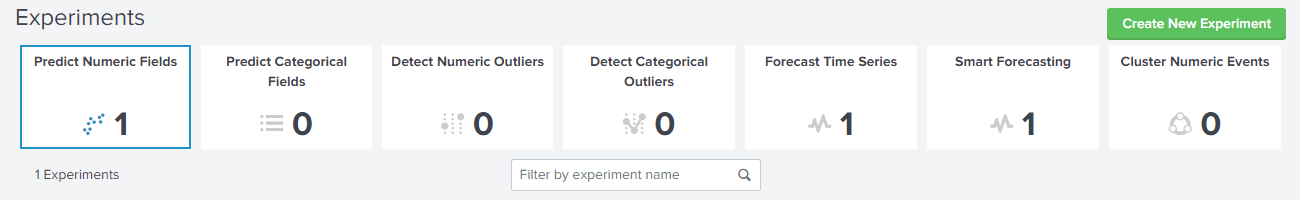

The relevant Assistants for this problem are:

* Smart Forecasting
* Predict numeric fields
* Forecast Time Series

In addition there is the underling Splunk command fit and apply for more advanced customization.


# Smart forecasting

From the splunk documentation smart forecasting seems to be the news and "best" option. Reading a bit more into the documentation the algorithm seems to be based on a kalman filter with some extra functionality.

First I had to define a SPL search that returned the data. I had to add the timechart command as a way for adding the missing data in desember 2017
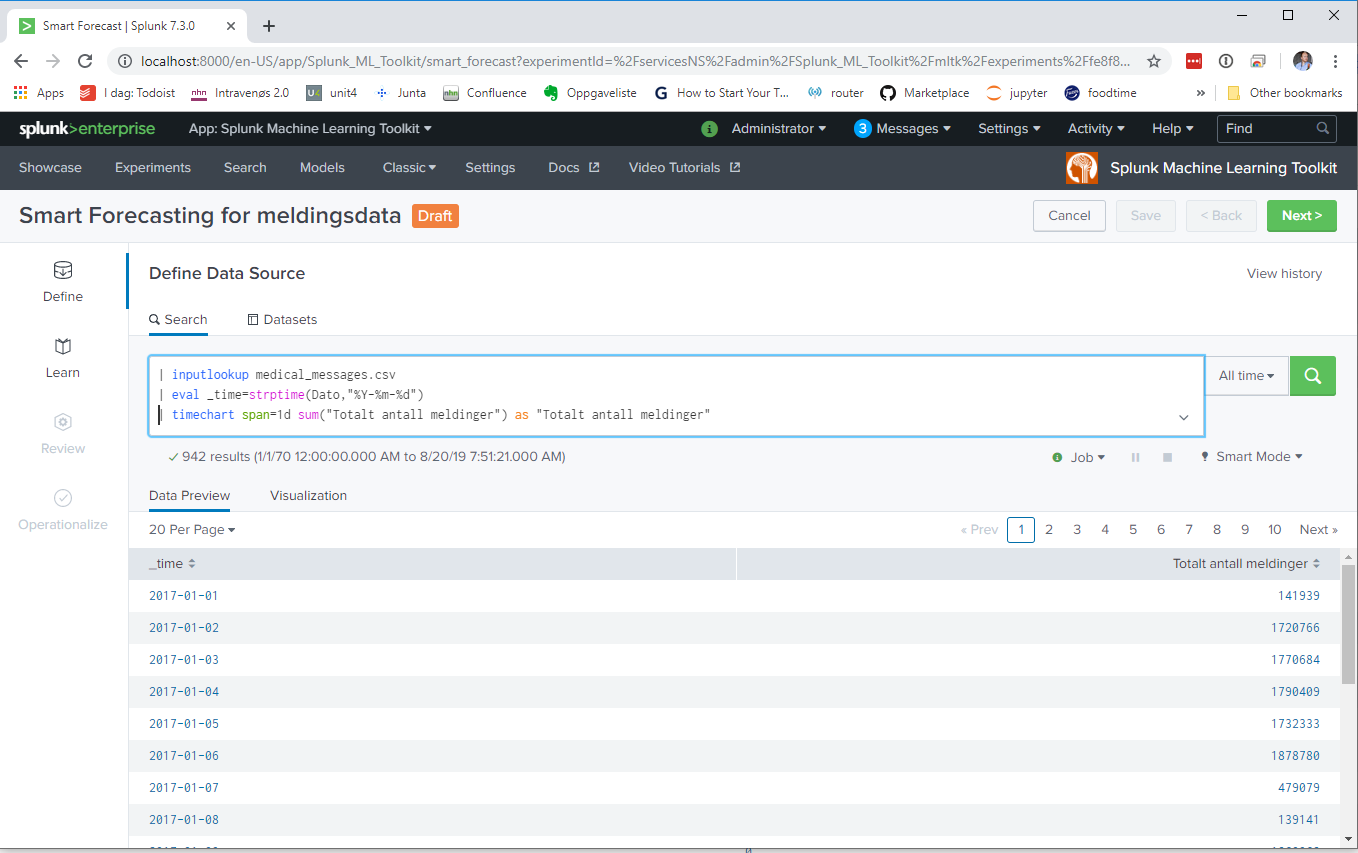

The next step was to define the parameters of the smart forecasting algorithm.  I wanted to use the same validation dataset as the previous notebook. Looking at the preiovus notebook I could see that there was in total 212 datapoint >2018.12.31. 
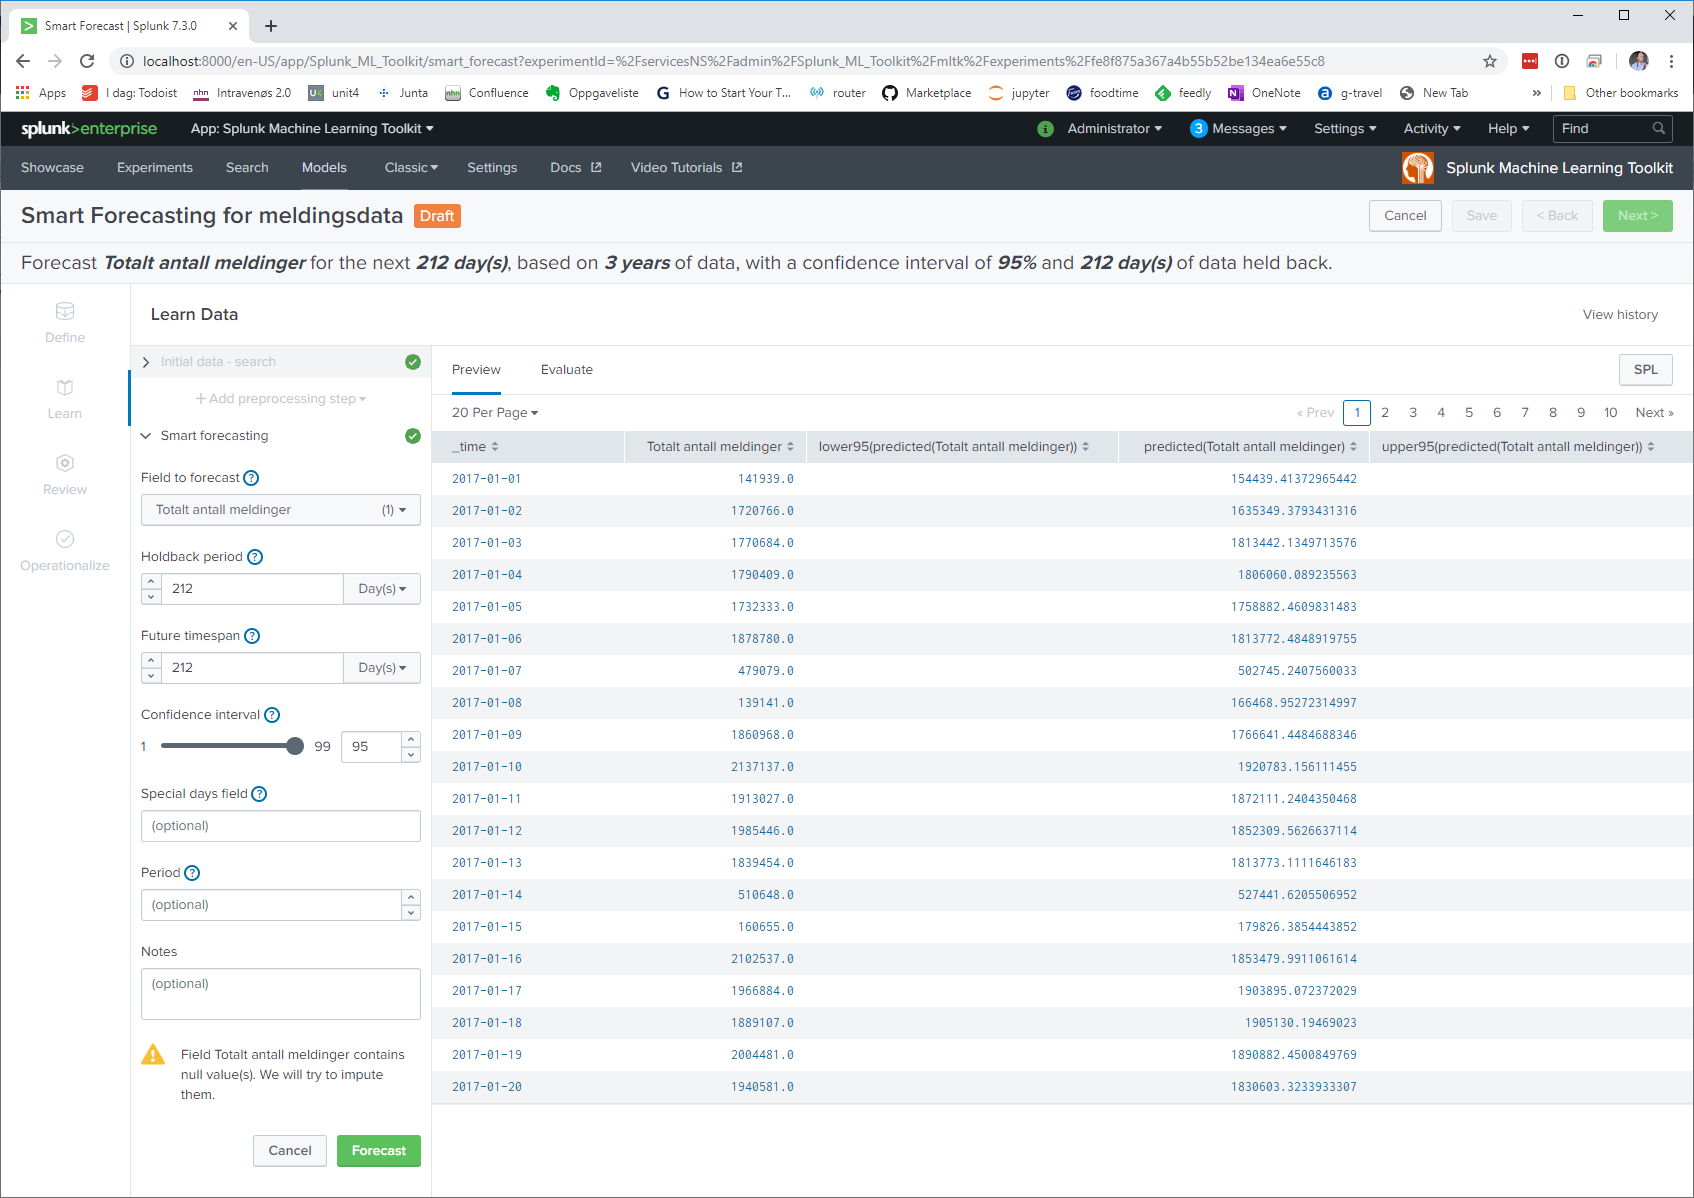

The next step is the review page
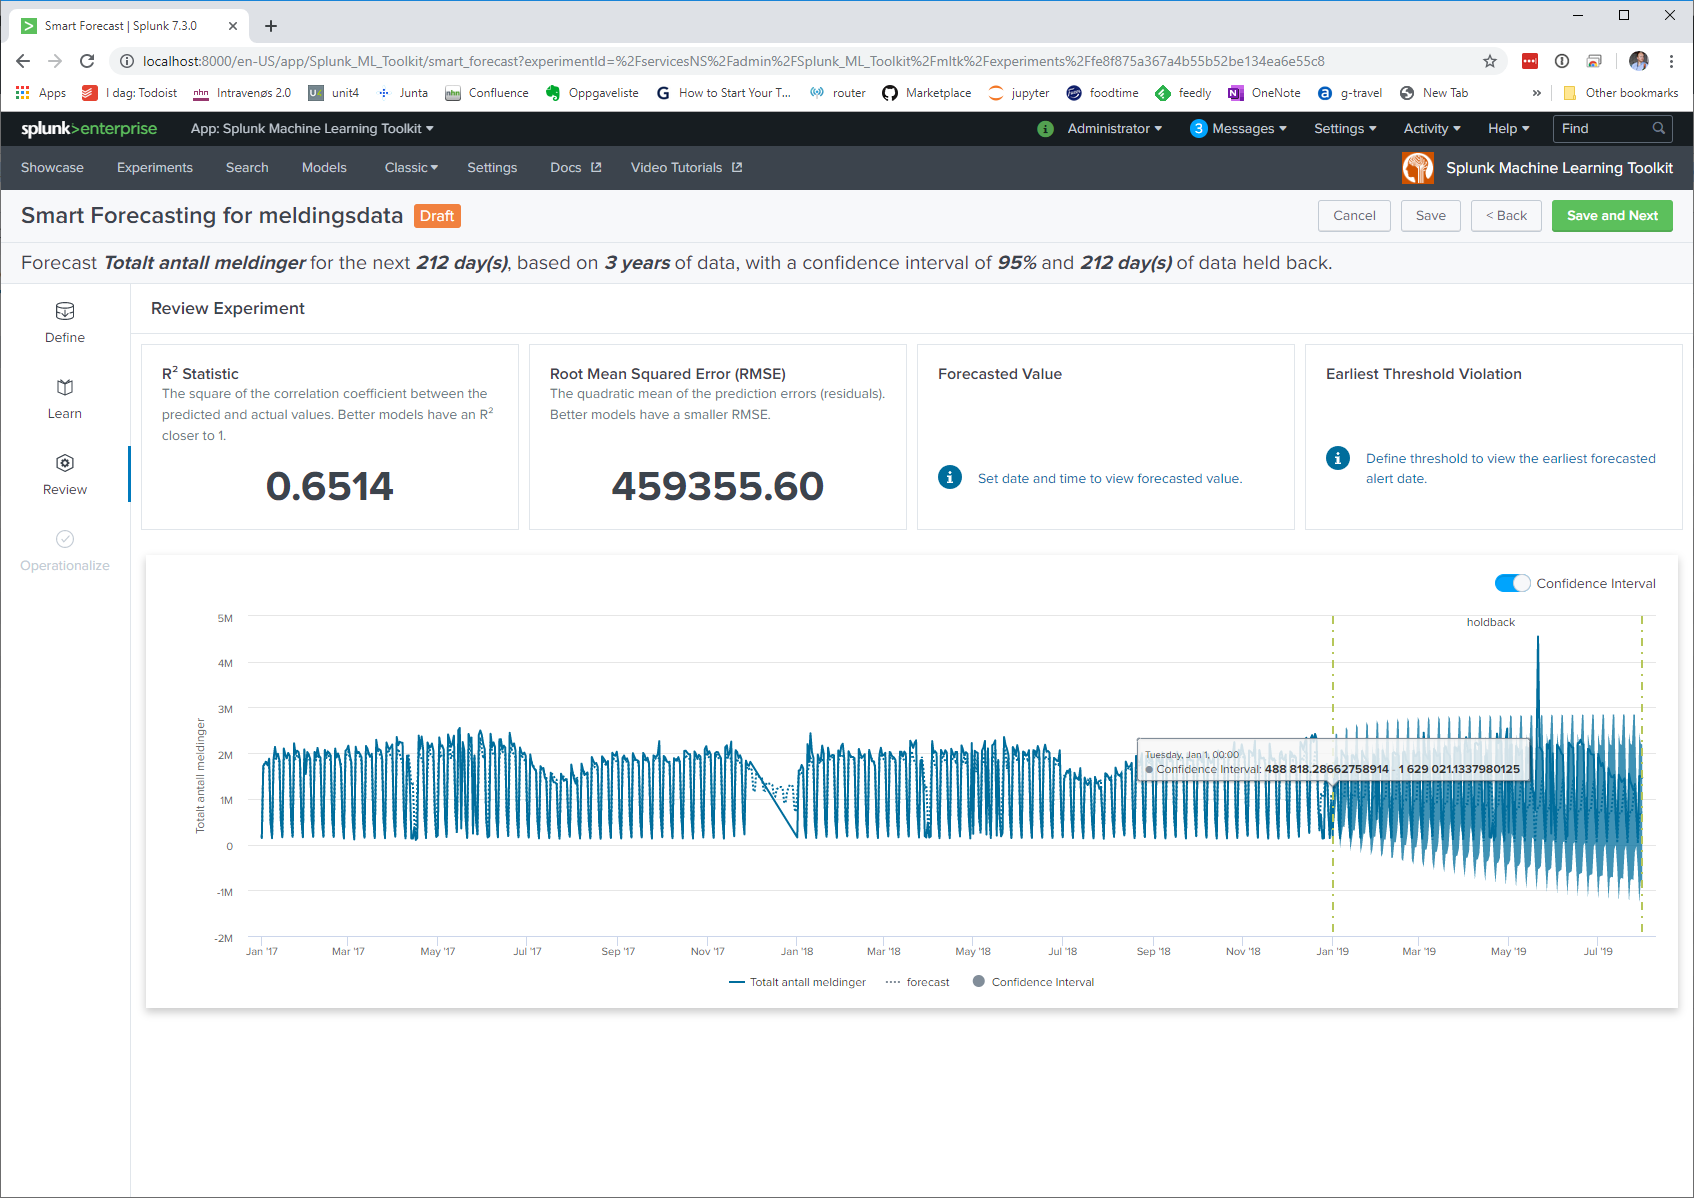

The RMSE error at 459 355 is quite a bit more than what we acived with some of the tree learning algorithms. 

In the next section I'm going to add holidays and a period of 7 days as parameters

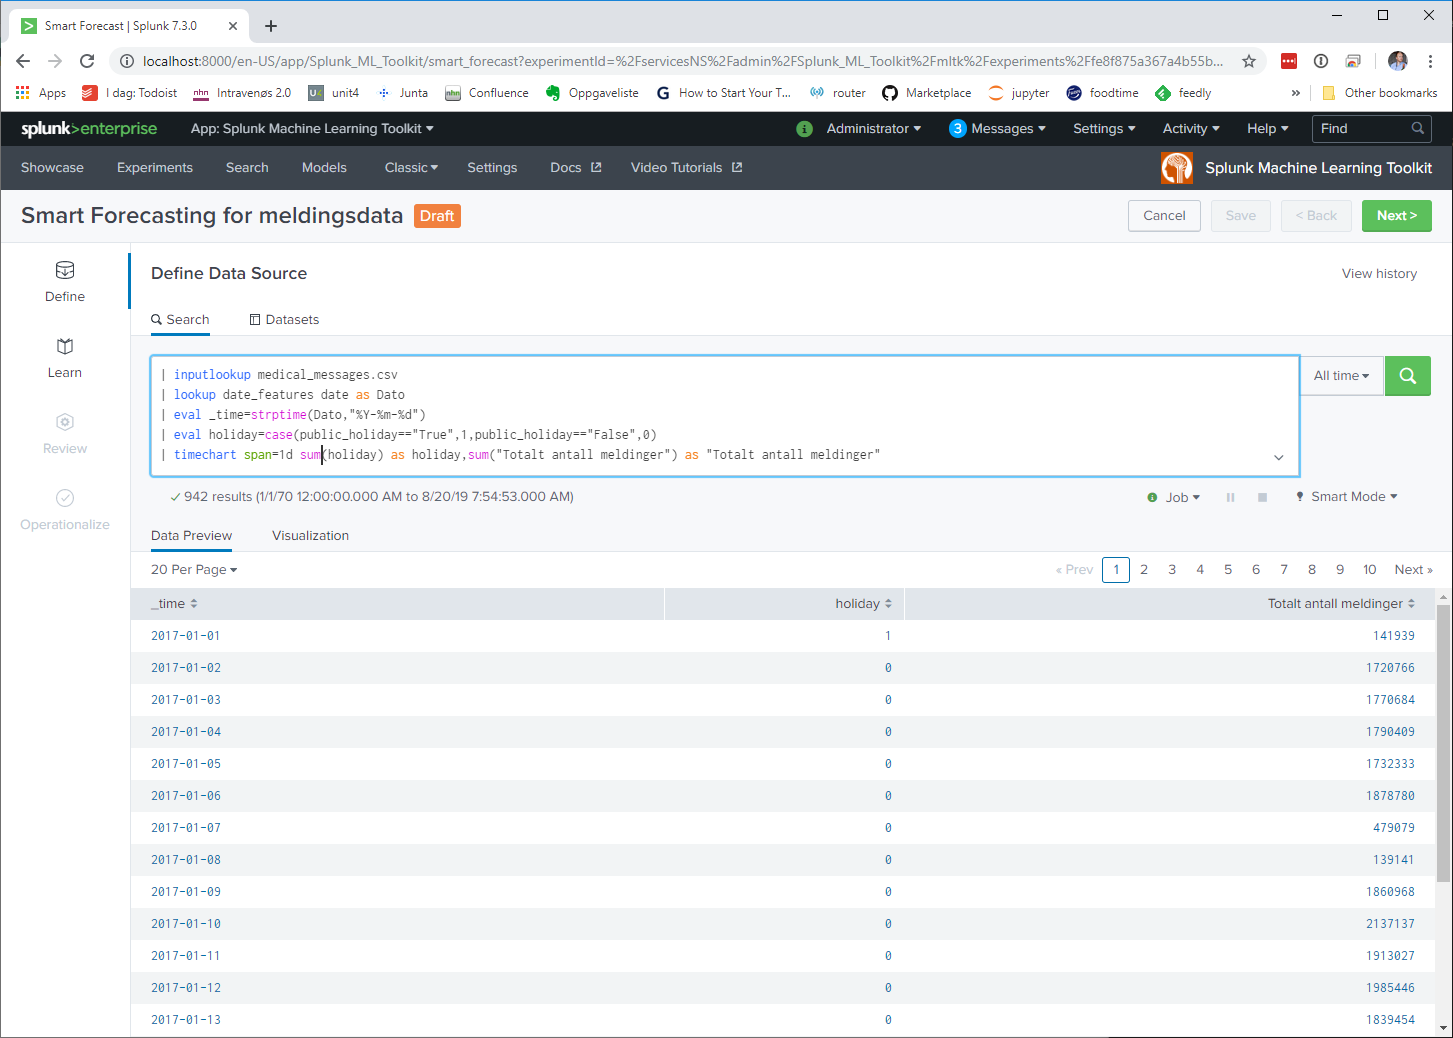

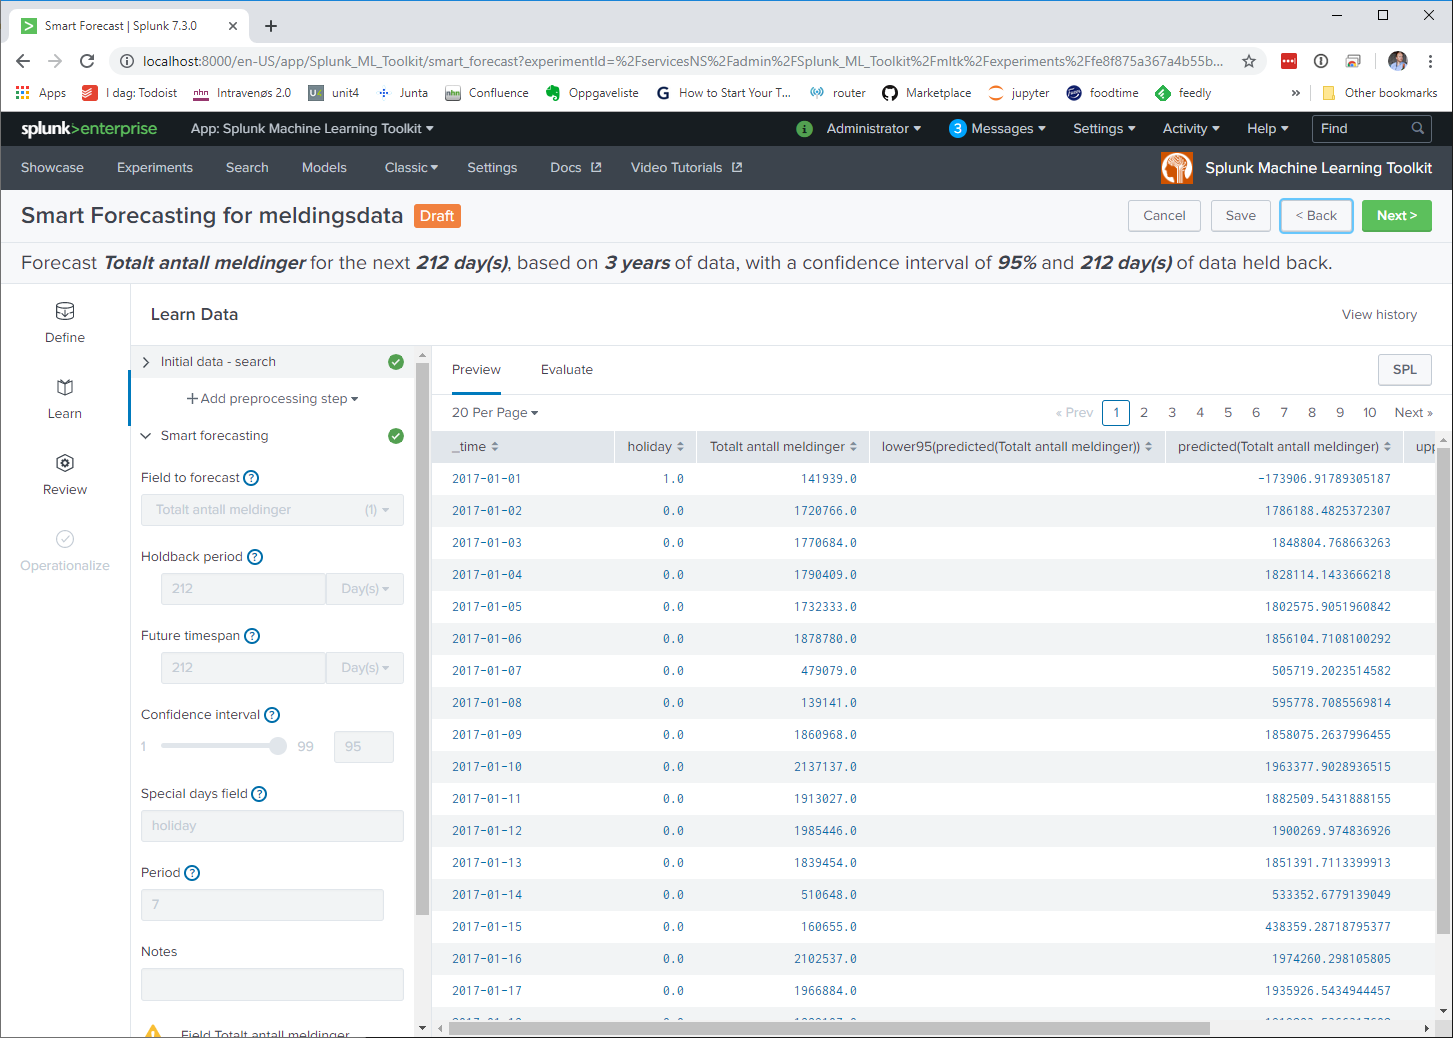

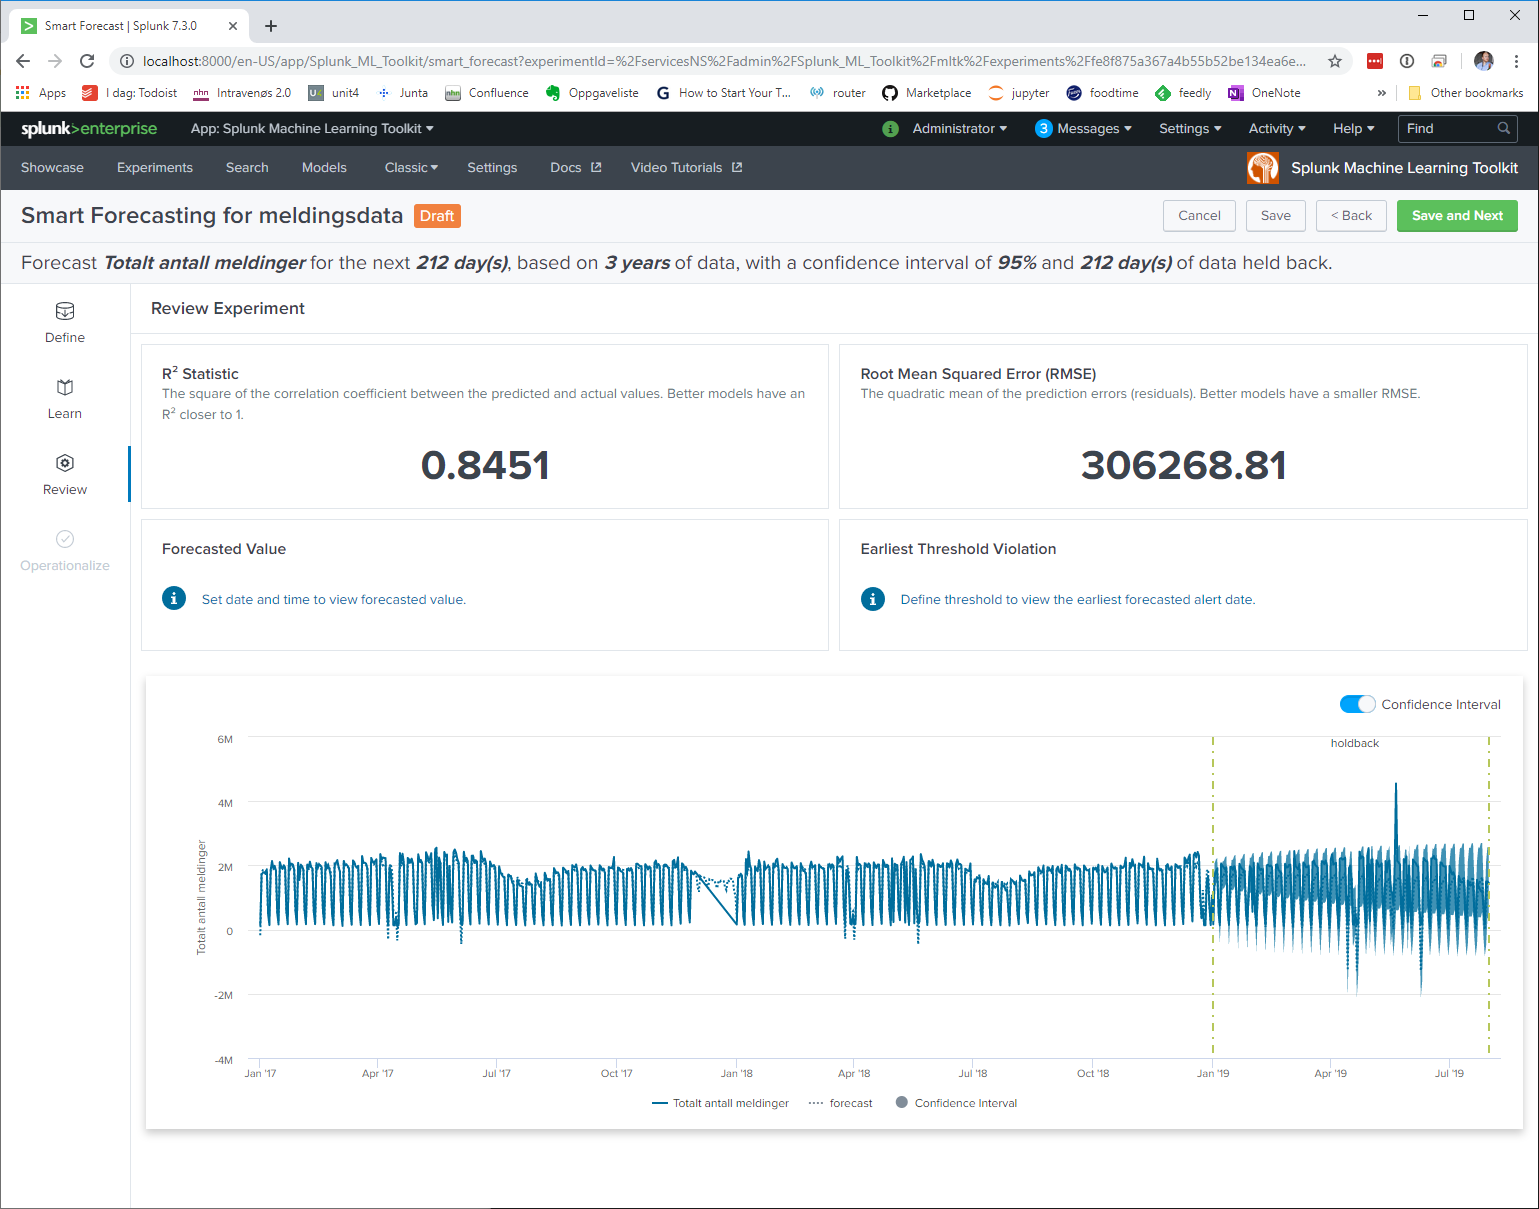

The RMSE error is improving bu still very high

# Predict numeric fields
With his Assistants its only possible to make percentage split of train/test data. Making it very hard to do time series prediction. The test data really need to be at the end of the timeseries and not in between the training data to be able to evaulate the algorithms ability to forecast into the future

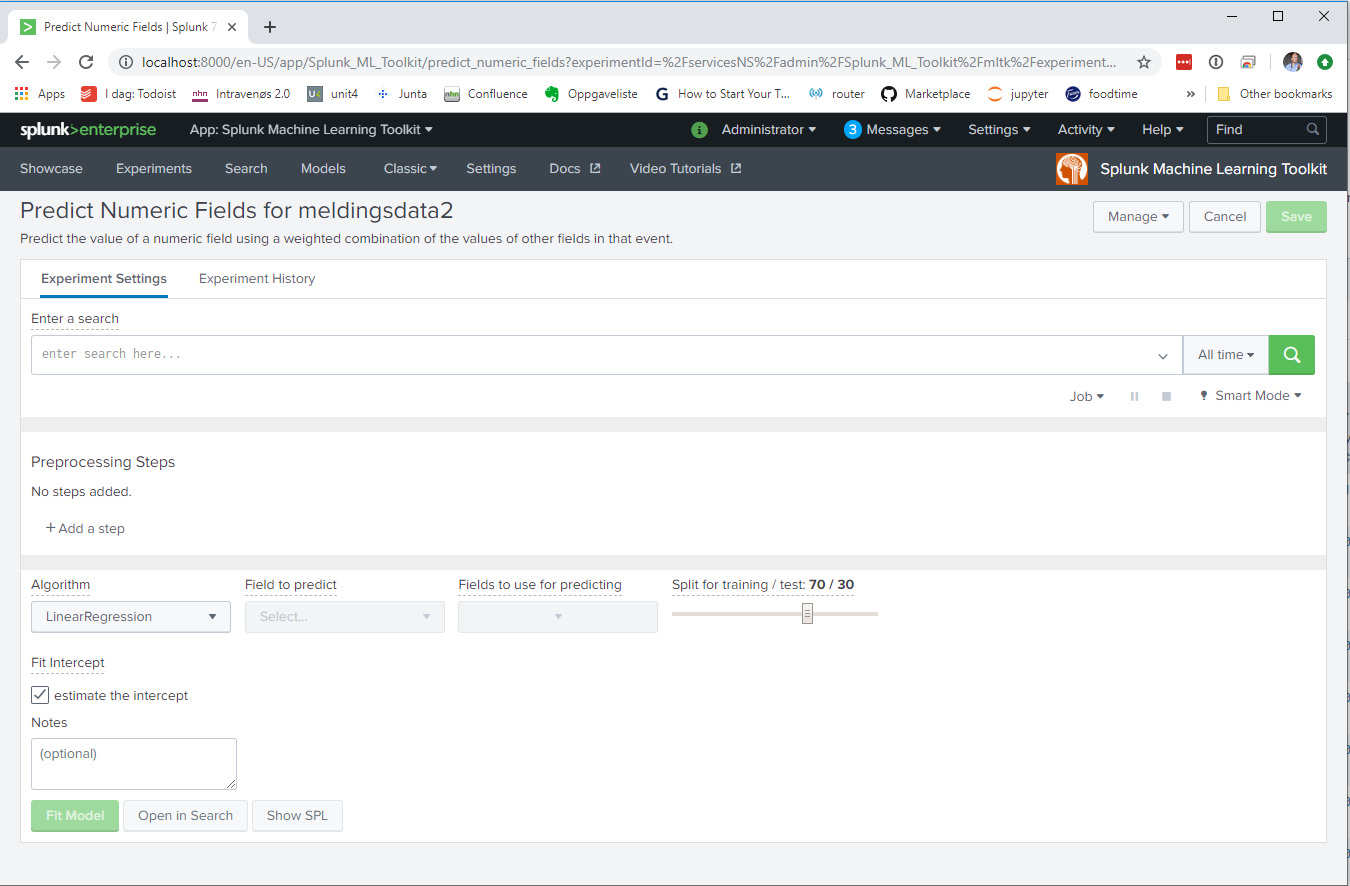

# Forecast Time Series


I got the following error testing this assisant. I don't think these algorithms would provide god results I have therefor not investigated more.
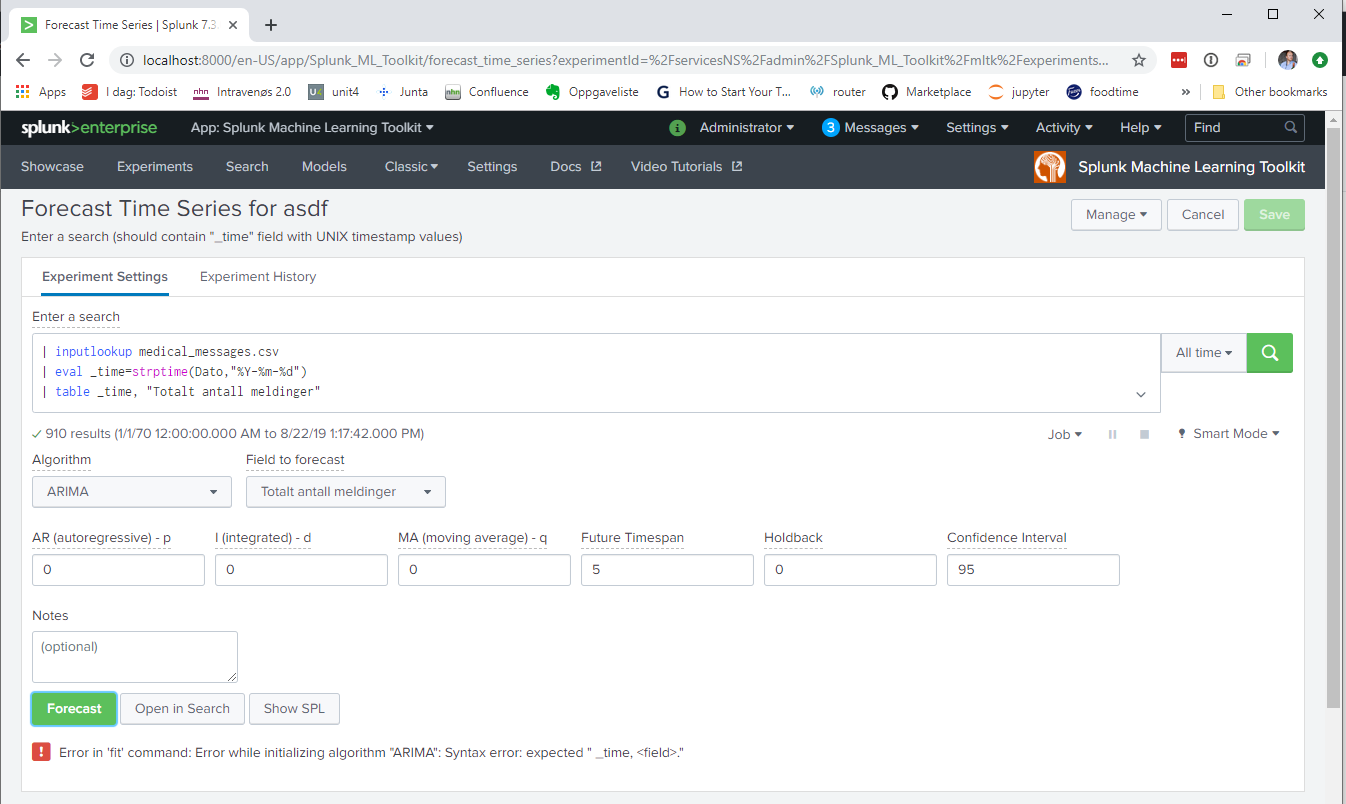

# Using SPL commands fit, apply, score

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import sklearn.metrics

In [3]:

#https://github.com/ogrodas/intake-splunk
#You will need this version that support splunk namespaces.

from intake_splunk.core import SplunkConnect
s=SplunkConnect("https://localhost:8089/")
s.auth("admin","superadmin")
s.set_namespace("admin","Splunk_ML_Toolkit")
SPL=s.read_pandas


In [4]:
df=SPL("""
| inputlookup medical_messages.csv 
| table Dato, "Totalt antall meldinger" 
| lookup date_features date as Dato 
| eval holiday=case(public_holiday=="True",1,public_holiday=="False",0) 
| eval _time=strptime(Dato,"%Y-%m-%d") 
| head 698 
| fit DecisionTreeRegressor "Totalt antall meldinger" from "Afterfreeday" "Beforefreeday" "Day" "Dayofweek" "Dayofyear" "Elapsed" "Is_month_end" "Is_month_start" "Is_quarter_end" "Is_quarter_start" "Is_year_end" "Is_year_start" "Month" "Week" "Year" "freeday" "freeday_bw" "freeday_fw" "inneklemt" "public_holiday" "workday" into "medical_messages_model"
""")
df.head()

Dato  Totalt antall meldinger  Afterfreeday  Beforefreeday  Day  \
0  2017-01-01                   141939             0              0    1   
1  2017-01-02                  1720766             1             -5    2   
2  2017-01-03                  1770684             2             -4    3   
3  2017-01-04                  1790409             3             -3    4   
4  2017-01-05                  1732333             4             -2    5   

   Dayofweek  Dayofyear     Elapsed  Is_month_end  Is_month_start  ...  \
0          6          1  1483228800         False            True  ...   
1          0          2  1483315200         False           False  ...   
2          1          3  1483401600         False           False  ...   
3          2          4  1483488000         False           False  ...   
4          3          5  1483574400         False           False  ...   

                           _time  freeday  freeday_bw  freeday_fw  holiday  \
0  2017-01-01T00:00:00.000+00:00     True         3.0         2.0        1   
1  2017-01-02T00:00:00.000+00:00    False         2.0         2.0        0   
2  2017-01-03T00:00:00.000+00:00    False         2.0         2.0        0   
3  2017-01-04T00:00:00.000+00:00    False         2.0         2.0        0   
4  2017-01-05T00:00:00.000+00:00    False         2.0         2.0        0   

   inneklemt  predicted(Totalt antall meldinger) public_holiday  \
0      False                            141939.0           True   
1      False                           1720766.0          False   
2      False                           1770684.0          False   
3      False                           1790409.0          False   
4      False                           1732333.0          False   

   public_holiday_name  workday  
0           nyttårsdag    False  
1                  NaN     True  
2                  NaN     True  
3                  NaN     True  
4                  NaN     True  

[5 rows x 27 columns]

In [5]:
df=SPL("""
| inputlookup medical_messages.csv 
| table Dato, "Totalt antall meldinger" 
| lookup date_features date as Dato 
| eval holiday=case(public_holiday=="True",1,public_holiday=="False",0) 
| eval _time=strptime(Dato,"%Y-%m-%d") 
| tail 212 
| apply medical_messages_model
""")
df.head()

Dato  Totalt antall meldinger  Afterfreeday  Beforefreeday  Day  \
0  2019-07-31                  1463038             3             -3   31   
1  2019-07-30                  1495934             2             -4   30   
2  2019-07-29                  1498761             1             -5   29   
3  2019-07-28                   148655             0              0   28   
4  2019-07-27                   698147             0              0   27   

   Dayofweek  Dayofyear     Elapsed  Is_month_end  Is_month_start  ...  \
0          2        212  1564531200          True           False  ...   
1          1        211  1564444800         False           False  ...   
2          0        210  1564358400         False           False  ...   
3          6        209  1564272000         False           False  ...   
4          5        208  1564185600         False           False  ...   

                           _time  freeday  freeday_bw  freeday_fw  holiday  \
0  2019-07-31T00:00:00.000+00:00    False         2.0         2.0        0   
1  2019-07-30T00:00:00.000+00:00    False         2.0         2.0        0   
2  2019-07-29T00:00:00.000+00:00    False         2.0         2.0        0   
3  2019-07-28T00:00:00.000+00:00     True         2.0         2.0        0   
4  2019-07-27T00:00:00.000+00:00     True         2.0         2.0        0   

   inneklemt  predicted(Totalt antall meldinger) public_holiday  \
0      False                           1488109.0          False   
1      False                           1488109.0          False   
2      False                           1559587.0          False   
3      False                            141496.0          False   
4      False                            884828.0          False   

   public_holiday_name  workday  
0                  NaN     True  
1                  NaN     True  
2                  NaN     True  
3                  NaN    False  
4                  NaN    False  

[5 rows x 27 columns]

In [6]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df["Dato"],y=df["Totalt antall meldinger"],name='validation',))
fig.add_trace(go.Bar(x=df["Dato"],y=df["predicted(Totalt antall meldinger)"],name='prediction',))

In [7]:
SPL("""
| inputlookup medical_messages.csv 
| table Dato, "Totalt antall meldinger" 
| lookup date_features date as Dato 
| eval holiday=case(public_holiday=="True",1,public_holiday=="False",0) 
| eval _time=strptime(Dato,"%Y-%m-%d") 
| tail 212 
| apply medical_messages_model
| score mean_absolute_error "Totalt antall meldinger" against "predicted(Totalt antall meldinger)"
""")

Dato  Totalt antall meldinger             Actual field  \
0   NaN                      NaN  Totalt antall meldinger   

                      Predicted field  mean_absolute_error  
0  predicted(Totalt antall meldinger)        194399.938679